# Proyecto 1 - Procesamiento Adaptativo de Señales
# Detección de arritmias

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import wfdb
import heartpy as hp
from scipy import signal

In [13]:
import numpy as np

class real_time_peak_detector():
    def __init__(self, array, width, threshold):
        """
        Parameters
        ----------
        array
            List or np.array of the first 'width' values in input signal.
        width
            A peak with index [i] will only be detected if it is the maximum value amongst the samples [i-width : i+width]
        threshold
            Minimum amplitude to be considered for peak detection
        """
        self.values = list(array)
        self.width = width
        self.threshold = threshold
        self.max_value = max(self.values)
        self.max_index = self.values.index(self.max_value)
        self.pslope = False

    def set_new_value(self, new_value):
        """
        Set new signal value and return whether there was a peak in the signal.
        
        Parameters
        ----------
        new_value
            New value in input signal.
        Returns
        -------
        bool
            True if there was a peak with index [i - peak_width + 1] relative to current sample index, False otherwise.
        """
        self.pslope = (self.values[1] > self.values[0])
        self.values = self.values[1:] + [new_value]
 
        if new_value > self.max_value:
            self.max_value = new_value
            self.max_index = self.width-1
        else:
            self.max_index -= 1

        if self.max_index == 0 and self.max_value > self.threshold and self.pslope:
            # Reset max values
            self.max_value = new_value
            self.max_index = self.width-1
            return True
        else:
            return False

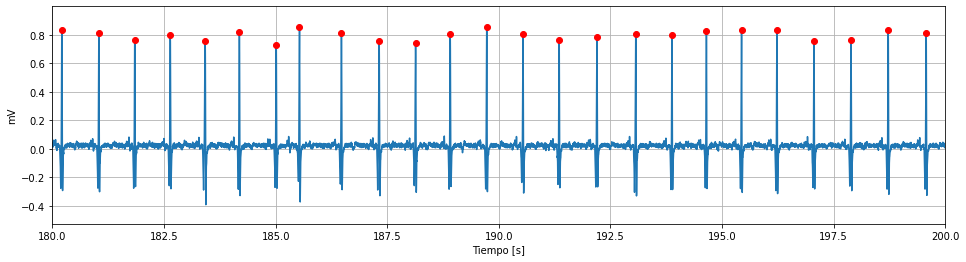

In [ ]:
N = 600000

record, record_data = wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/100', sampto=N)
annotation = wfdb.rdann('mit-bih-arrhythmia-database-1.0.0/100', 'atr', sampto=N)

fs = record_data['fs']
channel1 = hp.remove_baseline_wander(record[:,0], fs).reshape((N, 1))
channel1 -= np.mean(channel1)
time = np.arange(0, len(channel1)/fs, 1/fs)

time_start = 0
time_end = 1000

time = time[time_start*fs : time_end*fs]
channel1 = channel1[time_start*fs : time_end*fs]
N = time_end*fs - time_start*fs

peak_width = 30
peak_detector = real_time_peak_detector(channel1[:peak_width], peak_width, 0.25)

peaks = []
peaks_time_index = []

for i in range(peak_width, len(channel1.flatten())):
    if peak_detector.set_new_value(channel1[i]) > 0:
        peaks.append(i - peak_width + 1)

plt.figure(figsize=(16, 4))
plt.plot(time, channel1)
plt.plot(time[peaks], channel1[peaks], 'ro')

plt.xlabel('Tiempo [s]')
plt.ylabel(record_data['units'][0])
plt.xlim(180, 200)
plt.grid()
plt.show()

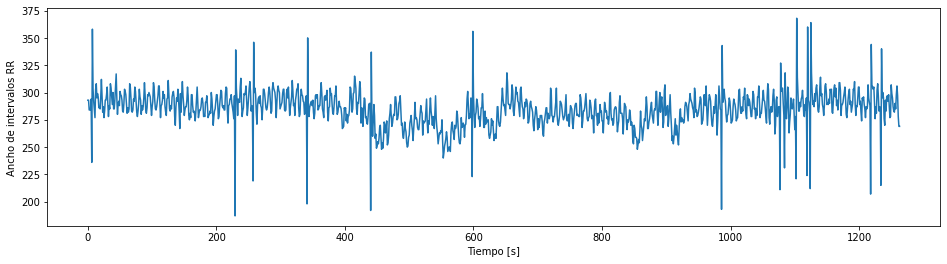

In [ ]:
plt.figure(figsize=(16, 4))
#plt.plot([t/fs for t in peaks[:-1]], np.diff(peaks))
plt.plot(np.diff(peaks))
plt.ylabel('Ancho de intervalos RR')
plt.xlabel('Tiempo [s]')
plt.show()

# LMS: RR Intervals signal

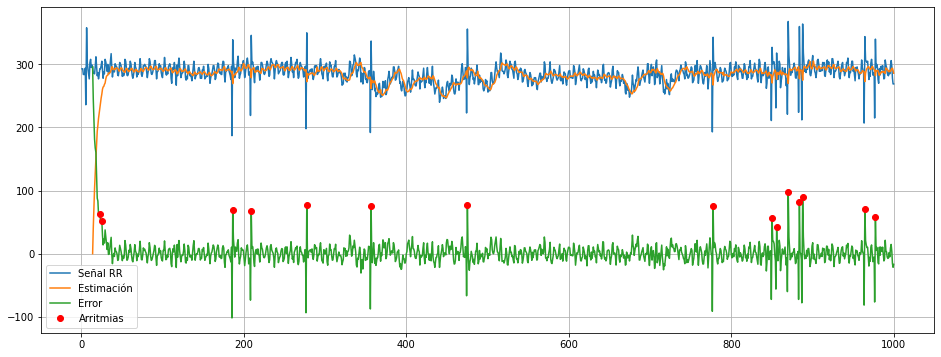

In [ ]:
# LMS
M = 16
w = np.zeros((M, 1))    # el vector queda en el orden inverso al tradicional
e = []
yhat = []
mu = 1e-7

offset = 0

peak_width = 30
peak_detector = real_time_peak_detector(channel1[ : peak_width], peak_width, 0.5)

peaks = np.array([])
RR = np.array([])
time_indexes = np.array([])

for i in range(peak_width, time_end*fs):
    if peak_detector.set_new_value(channel1[i]):
        peaks = np.append(peaks, i - peak_width + 1)
        if len(peaks)>1:
            RR = np.append(RR, peaks[-1] - peaks[-2])
            time_indexes = np.append(time_indexes, i/fs)

            if len(RR) > M:
                x = RR[-M-1 : -1].reshape((M, 1))
                y = RR[-1]

                yhat.append( (w.T @ x).item(0) )
                e.append( y - yhat[-1] )
                w = np.add(w, mu * e[-1] * x)

peaks, _ = signal.find_peaks(e, height=40)

plt.figure(figsize=(16, 6))
plt.plot(time_indexes, RR, label = 'Señal RR')
plt.plot(time_indexes[M:], yhat, label = 'Estimación')
plt.plot(time_indexes[M:], e, label = 'Error')
plt.plot([time_indexes[p+M] for p in peaks], [e[p] for p in peaks], 'ro', label = 'Arritmias')
plt.grid()
plt.legend()
plt.show()

# for t in [time_indexes[p+M] for p in peaks]:
#     print(int(t//60), ':', int(t)%60)

# LMS: Morfología usando señal de deltas

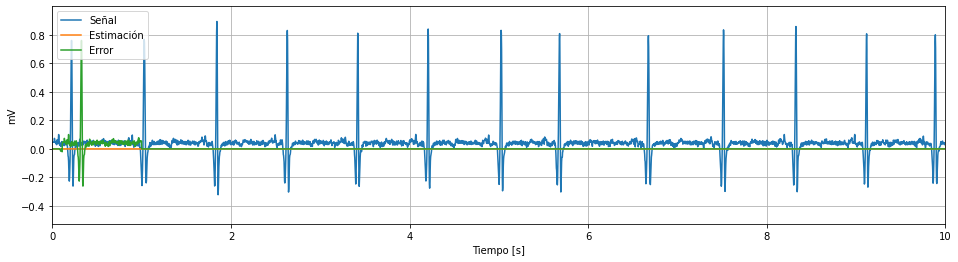

In [19]:
M = 512
w = np.zeros((M, 1))    # el vector queda en el orden inverso al tradicional
e = np.zeros(N)
yhat = np.zeros(N)
x = np.zeros((M, 1))
mu = 1e-4

peak_width = 30
peak_detector = real_time_peak_detector(channel1[ : peak_width], peak_width, threshold=0.5)

delay = peak_width + 10     # +10 para darle un poco de margen de seguridad

for i in range(peak_width, 1*360):#N):
    if peak_detector.set_new_value(channel1[i]):    # Hay un nuevo pico en [i - peak_width + 1] ?
        x = np.zeros((M, 1))
        x[-1] = 1

        #print('Pico:', i)
    else:
        x = np.roll(x, -1)
        x[-1] = 0

    y = channel1[i - delay]
    yhat[i] = (w.T @ x).item(0)
    e[i] = y - yhat[i]
    w = np.add(w, mu * e[i] * x)

plt.figure(figsize=(16, 4))
plt.plot(time, channel1, label = 'Señal')
plt.plot(time, yhat, label = 'Estimación')
plt.plot(time, e, label = 'Error')
plt.xlabel('Tiempo [s]')
plt.ylabel(record_data['units'][0])
plt.xlim(0, 10)
plt.grid()
plt.legend(loc='upper left')
plt.show()

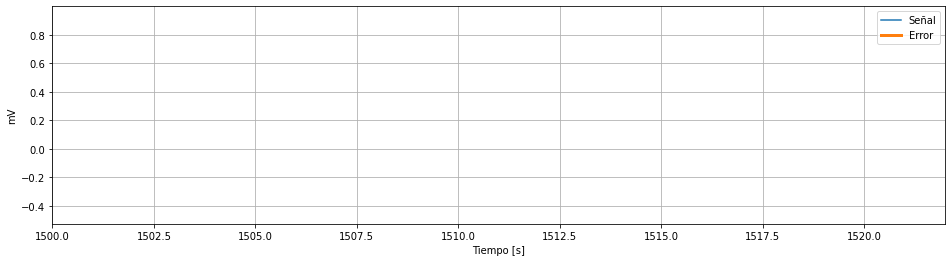

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(time, channel1, label = 'Señal')
plt.plot(time, e, label = 'Error', linewidth=3)
plt.xlabel('Tiempo [s]')
plt.ylabel(record_data['units'][0])
plt.xlim(1500, 1522)
plt.grid()
plt.legend()
plt.show()

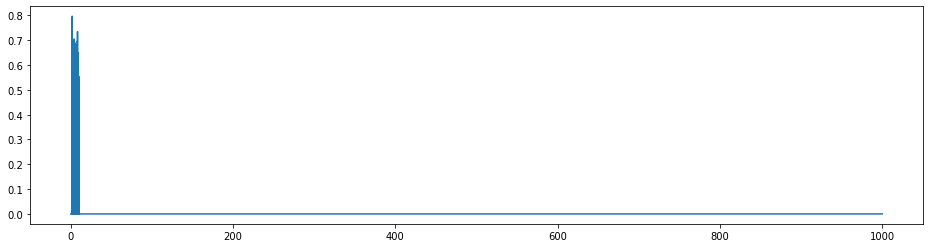

In [8]:
MSE = e**2 
plt.figure(figsize=(16, 4))
plt.plot(time, MSE)
plt.show()

ValueError: could not broadcast input array from shape (262144,) into shape (512,)

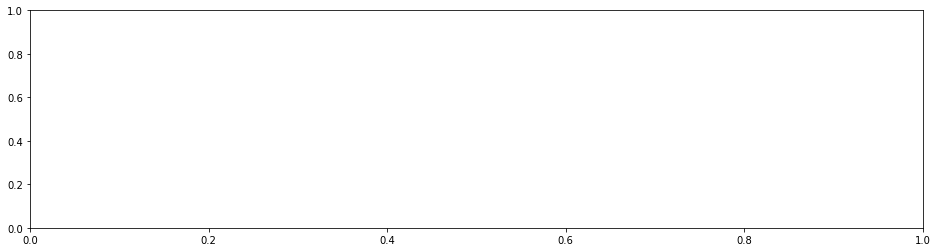

In [9]:
plt.figure(figsize=(16, 4))
plt.stem(np.flip(w))
plt.show()

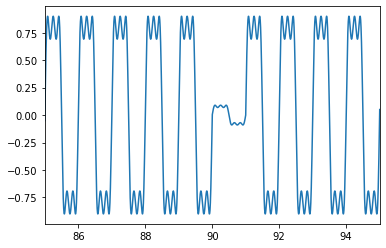

In [ ]:
# Señal de prueba
N = 36000

test_time = np.arange(0, 36000/360, 1/360)
test_channel1 = np.sin(2*np.pi*test_time) + 0.3*np.sin(2*np.pi*3*test_time)+ 0.2*np.sin(2*np.pi*5*test_time)
test_channel1[90*360:91*360] = 0.1 * test_channel1[90*360:91*360]
test_channel1 = test_channel1.T.reshape((36000, 1))

plt.xlim(85, 95)
plt.plot(test_time, test_channel1)

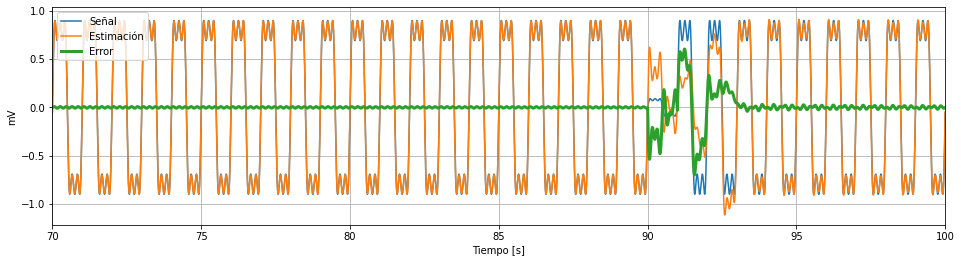

In [ ]:
#VSLMS
M = 512
w = np.zeros((M, 1))    # el vector queda en el orden inverso al tradicional
e = np.zeros(N)
yhat = np.zeros(N)
MSE = np.zeros(N)
mu = 1e-5 * np.ones(N+1)
a = 0.9
b = 1e-2
mu_max = 1e-4

delay = 100
offset = 0

for i in range(M+delay-1 + offset, 36000):#N):
    x = test_channel1[i-M-delay+1 : i-delay+1]
    y = test_channel1[i]
    yhat[i] = (w.T @ x).item(0)
    e[i] = y - yhat[i]
    MSE[i] = e[i]**2
    w = np.add(w, mu[i] * e[i] * x)
    mu[i+1] = min(mu_max, a*mu[i] + b*e[i]**2)


plt.figure(figsize=(16, 4))
plt.plot(test_time, test_channel1, label = 'Señal')
plt.plot(test_time, yhat, label = 'Estimación')
plt.plot(test_time, e, label = 'Error', linewidth=3)
plt.xlabel('Tiempo [s]')
plt.ylabel(record_data['units'][0])
#plt.xlim(1517, 1522)
plt.xlim(70, 100)
plt.grid()
plt.legend(loc = 'upper left')
plt.show()

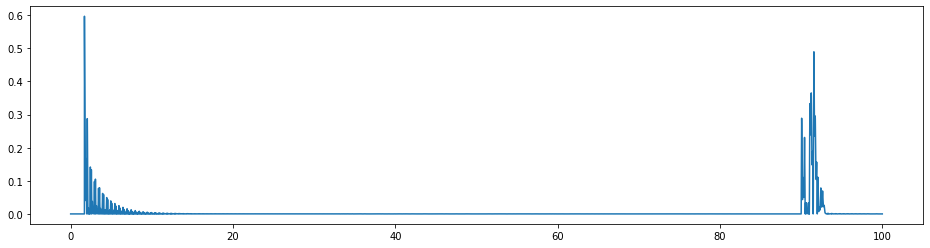

In [ ]:
MSE = e**2 
plt.figure(figsize=(16, 4))
plt.plot(test_time, MSE)
plt.show()

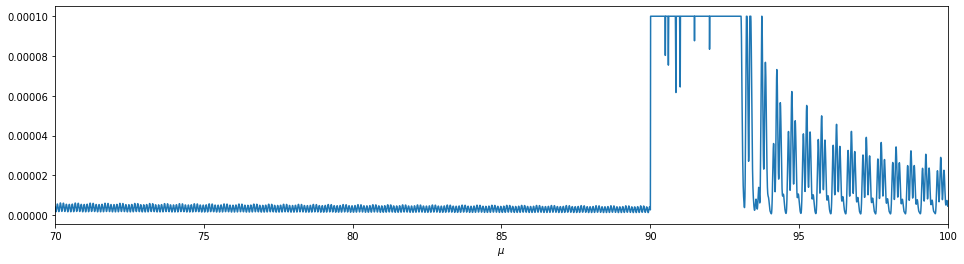

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(test_time, mu[:-1])
plt.xlabel('$\mu$')
plt.xlim(70, 100)
plt.show()

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(time_test, MSE)
plt.show()

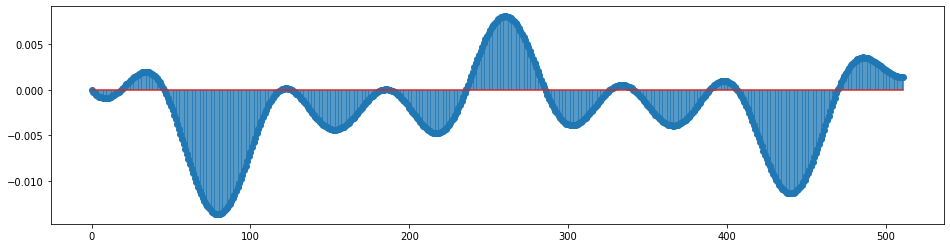

In [ ]:
plt.figure(figsize=(16, 4))
plt.stem(np.flip(w))
plt.show()